# Ultimate Fandoms

## 1 Motivation

Almost all people are interested in pop culture to some extent - some more than others of course. With the spread of the Internet in the 00’s, fans of the same books, movies, games, or music, etc. were given the opportunity to share and cultivate experiences about their common interests with each other. It was now easy to discuss one's passions with equally passionated people across the globe.

Today fandom is a widely know concept, and it seems like everyone are fans of something. Now, could there be a connection between the different type of passions? Is it more normal for people who love a particular game to also like other games, or would he or she rather follow up on a specific music band?

The activity from the different fandoms have given us the opportunity to investigate and clarify the interaction across the different communities. And this is exactly what we intend to do. We will investigate these connections by downloading data from the fandom platforms, and then creating and analyzing social graphs from the data. 

Specifically, we will use the platform fandom.com / wikia.com, which is a wiki hosting service where roughly all fandoms have a wiki. From the Fandom API (http://www.wikia.com/api/v1) we are able to collect data concerning the top contributing users for every fandom-wiki, discover how big the fanbase is and how the users create links between otherwise unconnected wikis.


#### Dataset

Our dataset consist of 35039 fandoms/wikis filtered down to 5585, and 22241 user accounts who contribute to the fandoms. This data has not been particularly easy to get a hold of since it turns out that the API is not being maintained by wikia. This information was given by George Marbulcanti (Kirkburn) a Senior Technical Community Support Specialist from Wikia.

In particular, the API call which should return the top wikis given the number of page-views is inconsitent since not all wiki pages count their page-views and activity. The wikia pages are all given individual freedom, which limit the data you can get.

So how did we manage to find our wikis and user data? All API calls give a maximum of 250 wikis per call. So we used the following method to get the data. You can see the code in this notebook: http://££££.
* Download top 250 wikis given page-views
* Search for wikis using hubs (categories e.g. Games or Music) as keywords
* Find the usernames of the top 10 active users and founder given by the wikis
* Search for new users using the known usernames as keywords
    * Saved in .txt file
* Scrap the html for the users' most recent activity to find links to other wikis
    * Saved in .txt file
* Search for the new wikis found on the user's pages and add to the wiki-list
* Add these new wikis' top 10 active users and founders to the user-list

This process can be run multiple times to gather more data. Though after adding the users' information (username and list of wikis they follow) to the text files once, finding new wikis and then adding these wikis' top 10 user, we had discovered the above mentioned users and wikis. The amount seems to be enough to gain some understanding of the full dataset. Our 35039 wikis are not close the the branded 385,000+ wikis (http://www.wikia.com/explore) though we will keep that in mind when looking into the data. 


In addition to the wiki and user data, we have included multiple articles form the different wiki in order to better understand the use of the language and overall sentiment. Here we believed it to be simple and use the API to get the top-viewed articles, forums and discussions from the different hubs, as there is an API for this. However, it turns out that 6/8 of the respones to the different hubs gave the same data, where George Marbulcanti explained that the API use not used or maintained.

Thanks to the different helping-forums we where able to get the main 25 article id for every wiki using something called *wkpoppages*. From these article ID's we could use the API i get the article text which is stored as json files. You can see the code in this notebook: http://££££.

#### Choice of datasets

Wikia is the first website which comes to mind when thinking about fandoms. It contains all the most passionate peoples' discussions and is free for everyone. It was (or seemed) easy to get data from though the API. For the particular data we ended up with having is a different story. The wikis we though where the most active wiki's turned out that most of them didn't even have any active users according to the dataset.

#### Goal for the end user's experience

The final goal is to understand which fandoms people are pationated about, as well as finding the connection between fandoms. What does the typical gamer have of other interest? Are people who are active in the gaming communities also interested in other topics, or is the typical fan only contained to one or two different areas?

## 2 Basic stats


### Data cleaning and preprocessing.

Since we had trouble collecting the data we nedded to remove duplicates and what appearded to be unactive wikis. To preprocess the data to be able to create the graph we decided to use wikis as nodes and connect them using the users. 



### Dataset stats 

In total we collected: 218.12 MB of data  (214 MB of text data, 2.42 MB of wiki data, 1.3 MB of user data, 0.4 MB data for word sentiment analysis). Not all article data ended up being used, due to the time it took to run through the hundreds of MB data. 

The graph ended up getting 5238 nodes and 45389 edges. 

The following section will show how we analysed the data as well as give an overview of it. The process is explained thoughout the rest of the notebook.

In [1]:
# Imports for the whole Analysis

#from urllib.request import urlopen
import json
import re
#from urllib.parse import quote
import pandas as pd
from pandas.io.json import json_normalize
import collections
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
import numpy as np
import datetime
import ast # string to dirc
import time
import community as cm
import matplotlib.cm as pltcm
import glob

# imports for text-analysis
import string
import nltk
from nltk.tokenize import RegexpTokenizer
# conda/pip install stop-words
from stop_words import get_stop_words
from nltk.corpus import stopwords
import math
from collections import Counter
from wordcloud import WordCloud
# conda install -c phlya adjusttext 
#from adjustText import adjust_text

The full saved dataset can be seen below. It contains 35039 rows with 20 attributes in each.

In [2]:
# Get wikis/dataset from csv
fullDataSet = pd.read_csv("data/sortedWikiData.csv", sep='\t')

# Drop old index column named "Unnamed: 0"
fullDataSet = fullDataSet.drop(['Unnamed: 0'], axis=1)
fullDataSet.head()

creation_date desc                  domain flags  founding_user_id  \
0  2006-01-10 15:06:36  NaN  broadcasting.wikia.com    []           12423.0   
1  2006-03-16 06:06:01  NaN     realitytv.wikia.com    []           19261.0   
2  2006-05-27 12:27:18  NaN         zh.tv.wikia.com    []           23838.0   
3  2006-07-05 12:34:17  NaN    tvchannels.wikia.com    []               0.0   
4  2006-03-16 13:42:45  NaN           mtv.wikia.com    []               0.0   

  headline hub    id image   lang language                        name  \
0      NaN  TV   942   NaN     en       en  Radio-TV Broadcast History   
1      NaN  TV  1245   NaN     en       en                  Reality TV   
2      NaN  TV  1592   NaN  zh-tw    zh-tw                      中文電視大典   
3      NaN  TV  1776   NaN     en       en                   Telepedia   
4      NaN  TV  2155   NaN     en       en                    MTV Wiki   

  original_dimensions                                              stats  \
0                 NaN  {'edits': 24380, 'articles': 4362, 'pages': 56...   
1                 NaN  {'edits': 2812, 'articles': 59, 'pages': 601, ...   
2                 NaN  {'edits': 18338, 'articles': 977, 'pages': 403...   
3                 NaN  {'edits': 2097, 'articles': 92, 'pages': 210, ...   
4                 NaN  {'edits': 2139, 'articles': 56, 'pages': 227, ...   

                        title  \
0  Radio-TV Broadcast History   
1                  Reality TV   
2                      中文電視大典   
3                   Telepedia   
4                    MTV Wiki   

                                            topUsers      topic  \
0  [4106832, 27024879, 36887098, 37504326, 268032...  Education   
1                                [24878039, 1094479]         TV   
2  [36879666, 36808293, 36843235, 4784321, 581119...         TV   
3                     [30349598, 35485334, 36156286]         TV   
4                       [34715148, 28602916, 957747]      Music   

                             url  wam_score wordmark  
0  http://broadcasting.wikia.com     2.4801      NaN  
1     http://realitytv.wikia.com     0.0000      NaN  
2         http://zh.tv.wikia.com     4.7445      NaN  
3    http://tvchannels.wikia.com     0.0000      NaN  
4           http://mtv.wikia.com     0.0000      NaN

The *findActiveWikis* method clean up the data according the the description earlier. 

In [3]:
# Methode that remove inactive wikis and duplicates
def findActiveWikis(dataSet):
    activeDataSet = pd.DataFrame()
    
    # Remove duplicates
    dataSet = dataSet.drop_duplicates()
    
    # Find stats in dataset
    for wiki in dataSet.T.items():
        wiki = wiki[1]
        stats = wiki['stats']
        
        # Only add wiki to list when at in contains at least 1 active user
        sDirc = ast.literal_eval(stats)
        if int(sDirc['activeUsers'])>1:
            activeDataSet = activeDataSet.append(wiki) 
    
    # Create new index
    activeDataSet = activeDataSet.reset_index(drop=True)
    return activeDataSet

In [4]:
### Filter Wiki Data ###
activeDataSet = findActiveWikis(fullDataSet)

print("%s Wikis before filter, and %s Wikis efter filter.\n%s has been removed" % 
      (len(fullDataSet),len(activeDataSet),len(fullDataSet)-len(activeDataSet)))

activeDataSet.head()

# Data memory usage
print(sum(activeDataSet.memory_usage(index=False, deep=True))/1000)

35039 Wikis before filter, and 5585 Wikis efter filter.
29454 has been removed
7978.467


The Wikis will be the nodes of our network, however we need to connect these nodes. We will do this by finding multiple user profiles and connecting all the wikis which the individual user is active in. The users will thereby create small cliques, that in the end will give a knowledge over which wikis are the most connected.

In [5]:
# Methode that tage a string representing a list and makes it into a list
def makeStringToList(string):
    if string == "[]":
        return []
    string = string.replace("['","")
    string = string.replace("']","")
    
    # Some Wikis have '_' instead og ' ', which needs to be replaced. 
    string = string.replace("_"," ")
    listCreated = string.split("', '")
    return listCreated

In [6]:
### Get Users from user-wikis ###
users = {}

# Open file
filename = "data/users/user-wikis.txt"
f = open(filename, "r", encoding="utf8")

# Read content and create dircetory of wikis the users are active in
for line in f.read().splitlines():
    user = line.split(': ')
    if len(user) == 2:
        if user[0] not in users:
            users[user[0]] = []
            
        # Remove duplicates and add to the list
        users[user[0]] = list(set(users[user[0]]+makeStringToList(user[1])))

print("%s users have been found in user-wikis.txt" % len(users))

22241 users have been found in user-wikis.txt


### Creating the network

The network is going to be a undirected graph containing multilple cliques. The nodes will be the wikis with the attributes: Hub, allUsers and activeUsers according to the dataset, and usersOccurances, which is the number of times the wiki is mentioned in our user data: user-wikis.txt.

In [7]:
# Make graph
G = nx.Graph()

In [8]:
# Add nodes and attributes
duplicate_name_node_count = 0
for wiki in activeDataSet.T.items():
    wiki = wiki[1]
    name = wiki['name']
    
    # If wiki is NaN do not create node
    if str(name) == "nan":
        print("Do not add wiki if it is NaN (%s)" % name)
        continue
    
    # Make name fit wiki name in user-wikis.txt
    name = name.replace("_"," ")

    # Find hub value
    hub = wiki['hub']
    
    # Find topic values
    topic = ''
    if str(wiki['topic']) != 'nan':
        topic = wiki['topic']
    
    # Find user values
    stats = ast.literal_eval(wiki['stats'])
    allUsers = stats['users']
    activeUsersStats = stats['activeUsers']
    
    # Count occurances in user-wikis.txt
    usersOccurances = 0
    for values in users.values():
        for value in values:
            if value == name:
                usersOccurances+=1
    
    # Check if Wiki Name have a node
    if name not in G.nodes():
        # Create new node
        G.add_node(name, 
                   hub=hub, 
                   topic=topic,
                   allUsers=allUsers, 
                   activeUsers=activeUsersStats, 
                   usersOccurances=usersOccurances)
    else:
        # Update excisting node by merging new values
        duplicate_name_node_count+=1
        if hub not in G.node[name]['hub']:
            G.node[name]['hub'] = G.node[name]['hub']+", "+hub
        
        if topic not in G.node[name]['topic']:
            G.node[name]['topic'] = G.node[name]['topic']+", "+topic
        
        # Find average of the user numbers 
        # taking into account if one user is member of both Wikis
        if G.node[name]['allUsers'] != allUsers:
            G.node[name]['allUsers'] = str(int((int(G.node[name]['allUsers'])+int(allUsers))/2))  
                                                                                                                                
        if G.node[name]['activeUsers'] != activeUsersStats:
            G.node[name]['activeUsers'] = str(int((int(G.node[name]['activeUsers'])+int(activeUsersStats))/2))  
        
        # If different number of occurances (should not happend), then return the sum
        if G.node[name]['usersOccurances'] != usersOccurances:
            G.node[name]['usersOccurances'] = str(int(G.node[name]['usersOccurances'])+int(usersOccurances)) 

print("Number of nodes added to the graph: %s,\nNumber of nodes merged: %s,\nNumber of wikis: %s" % 
      (duplicate_name_node_count, len(G.nodes()), len(activeDataSet)))

Do not add wiki if it is NaN (nan)
Number of nodes added to the graph: 346,
Number of nodes merged: 5238,
Number of wikis: 5585


The above describtions to not fit the numbers the correct description is:
* Number of nodes found to be dublicates: 346,
* Number of nodes added to the graph: 5238,
* Number of wikis in total: 5585

In [9]:
# Methodes that create edges between all wikis which share users (cliques)
def createEdges(G,userWikis):
    length = len(userWikis)
    
    # Check if it is the last wiki in the list
    if length<=1:
        return G
    
    # Resursive call
    elif length>1:
        wiki = userWikis.pop()
        # Check wiki exsist in dataset
        if wiki in G.nodes():
            wikisNotInDataSet = []

            # Create edges
            for w in userWikis:
                if w in G.nodes():
                    if G.has_edge(wiki, w):
                        G[wiki][w]['weight']+=1
                    else:
                        G.add_edge(wiki,w,weight=1)
                else:
                    wikisNotInDataSet.append(w) 
            # Remove wikis which are not a part of our dataset
            if len(wikisNotInDataSet) > 0:
                length = len(userWikis) 
                userWikis = list(set(userWikis) - set(wikisNotInDataSet))
        return createEdges(G,userWikis)
    else:
        # Return final grph with edges
        return G

In [10]:
# iterate over all users
for k,v in users.items():
    # Create cliques between wiki nodes when user follows them
    G = createEdges(G,set(v))

# Discover number of edges
print("Number of edges added to the graph: %s" % len(G.edges()))

Number of edges added to the graph: 45389


### Draw network in graph colored by the hub type
The graph contains the nodes and edges. For one to understand the graph it is interesting to draw the graph

In [11]:
# Set layout
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1,

                          # Performance
                          jitterTolerance=0.5,  #1 # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=0.01, #0.01
                          strongGravityMode=False, #False
                          gravity=30, #15

                          # Log
                          verbose=True)


# Calculate Positions
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

100%|██████████| 2000/2000 [03:49<00:00,  8.93it/s]


BarnesHut Approximation  took  61.95  seconds
Repulsion forces  took  148.61  seconds
Gravitational forces  took  1.54  seconds
Attraction forces  took  3.14  seconds
AdjustSpeedAndApplyForces step  took  6.29  seconds


In [12]:
# Divide wikis according to hub
hubs = {}
for n in G.nodes(): 
    # Set the node type to only be the initial hub mentioned
    nodehub = G.node[n]['hub'].split(', ')[0]
    
    # Add hub to dirc
    if nodehub not in hubs:
        hubs[nodehub] = []
    hubs[nodehub].append(n)

# Print result
summ = 0
for k, v in hubs.items():
    summ += len(v)
    print("The hub %s has %s wikis from this dataSet" % (k, len(v)))

print("The sum of all are %s, which is the same as the %s number of nodes" % (summ,len(G.nodes())))

The hub TV has 1031 wikis from this dataSet
The hub Games has 2193 wikis from this dataSet
The hub Movies has 385 wikis from this dataSet
The hub Lifestyle has 657 wikis from this dataSet
The hub Books has 430 wikis from this dataSet
The hub Comics has 340 wikis from this dataSet
The hub Music has 192 wikis from this dataSet
The hub Other has 10 wikis from this dataSet
The sum of all are 5238, which is the same as the 5238 number of nodes


The graph can be drawn in multiple different ways. To make it easy the node-size-calculations have their own method

In [13]:
# Calculate node size according to frequency
def nodeSizeFrequency(nodeList):
    size = []
    for i in range(len(nodeList)):
        if str(nodeList[i]) == "nan":
            continue
        activeUsers = int(G.nodes[nodeList[i]]['activeUsers'])
        size.append(activeUsers)
    return size

In [14]:
# Calculate node size according to degree
def nodeSizeDegree(nodeList):
    return [G.degree(node, weight='weight') for node in nodeList]

In [15]:
# Calculate node size according to occurances in user-wikis.txt
def nodeSizeOccurances(nodeList):
    size = []
    for i in range(len(nodeList)):
        if str(nodeList[i]) == "nan":
            continue
        usersOccurances = int(G.nodes[nodeList[i]]['usersOccurances'])*15  
        size.append(usersOccurances)
    return size

To calculate the sizes and create a graph according to the different hubs, the method *createNodeSizes* was generated as well as *drawAndSaveGraph*. 

In [16]:
# Calculate node sized for all hubs according to a specific methode
def createNodeSizes(sizeMethode, hubs, betweenness_centrality=None):
    node_size = {}
    for hub in hubs.keys():
        if betweenness_centrality==None:
            node_size[hub] = sizeMethode(hubs[hub])
        else:
            node_size[hub] = sizeMethode(hubs[hub], betweenness_centrality)
    return node_size

In [17]:
# Drawing and saving the graph with different colored hubs and nodesizes
def drawAndSaveGraph(hight, width, G, positions, hubs, node_size, max_size_lable, grapgName):
    # plot figure
    plt.figure(figsize=(hight, width))  

    labels = {}    
    for k,v in hubs.items():
        hub_sizes = node_size[k]
        for i in range(len(v)):
            if hub_sizes[i] > max_size_lable:
                #set the node name as the key and the label as its value 
                labels[v[i]] = v[i]


    node_label = [node for node in G.nodes()]
    colors = ['red', 'brown', 'yellow', 'orange', 'lightgreen', 'green', 'lightblue', 'pink']
    
    j = 0
    for hub in hubs.keys():
        nx.draw_networkx_nodes(G, positions, nodelist=hubs[hub], node_size=node_size[hub],cmap=plt.get_cmap('jet'), node_color=colors[j], label=hub)
        j+=1
    
    nx.draw_networkx_edges(G, positions, width=0.1, cmap=plt.get_cmap('jet'), edge_color="gray")
    nx.draw_networkx_labels(G, positions, labels=labels, font_size=19, font_color='k', font_weight='bold', alpha=2.0)

    plt.legend(numpoints = 1)
    plt.title(grapgName)
    #texts = [plt.text(n, labels[n], ha='center', va='center') for n in G.nodes()]
    #adjust_text(texts)#, only_move='y', arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
    plt.axis('off')
    plt.savefig('graphs/'+grapgName+'.png')
    plt.show()

**Now lets see the graphs!**

There are three graphs in the following code blocks:
 * Graph with node size according to degree
 * Graph with node size according to the number of times a user from our dataset follows the wikis
 * Graph with node size according to the number of active users given in the wikia dataset 

TV 283 0 21.680892337536374
Games 269 0 14.801641586867305
Movies 225 0 19.296103896103897
Lifestyle 266 0 24.226788432267885
Books 217 0 17.141860465116277
Comics 252 0 24.270588235294117
Music 272 0 21.484375
Other 67 0 26.7


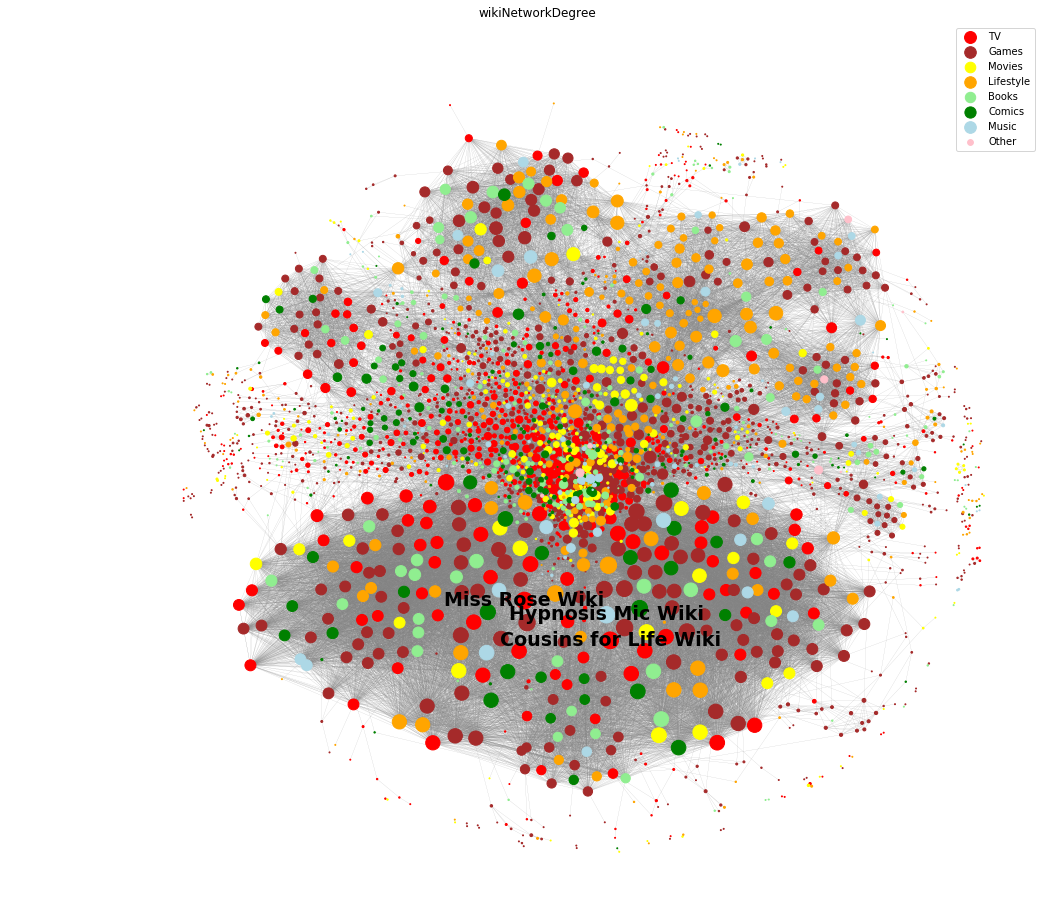

In [18]:
node_size = createNodeSizes(nodeSizeDegree, hubs) 
for k,v in node_size.items():
    print(k, max(v), min(v), np.average(v))

drawAndSaveGraph(18, 16, G, positions, hubs, node_size, 270, 'wikiNetworkDegree')

The above graph is a we expect. The nodes close to the middel are larger, than the ones at the edge. The largest and thereby those with the most degrees are are the nodes: 
* Hypnosis Mic Wiki (Music)
* Miss Rose Wiki (TV)
* Cousins for Life Wiki (TV)
All nodes with labels on the graph have a degree (with weight) above 270.

The data printed on top of the graph explains the following:
* Hub, max degree within hub, min degree within hub, and average degree within hub.

Her it is interesting to notice that there is a large span from the max degree to the average, whick is interesting to remember when we look into the degree distribution later.

TV 645 0 91.51309408341416
Games 675 0 70.5813953488372
Movies 975 0 82.75324675324676
Lifestyle 315 0 64.65753424657534
Books 1020 0 72.34883720930233
Comics 585 0 94.5
Music 540 0 72.265625
Other 135 30 73.5


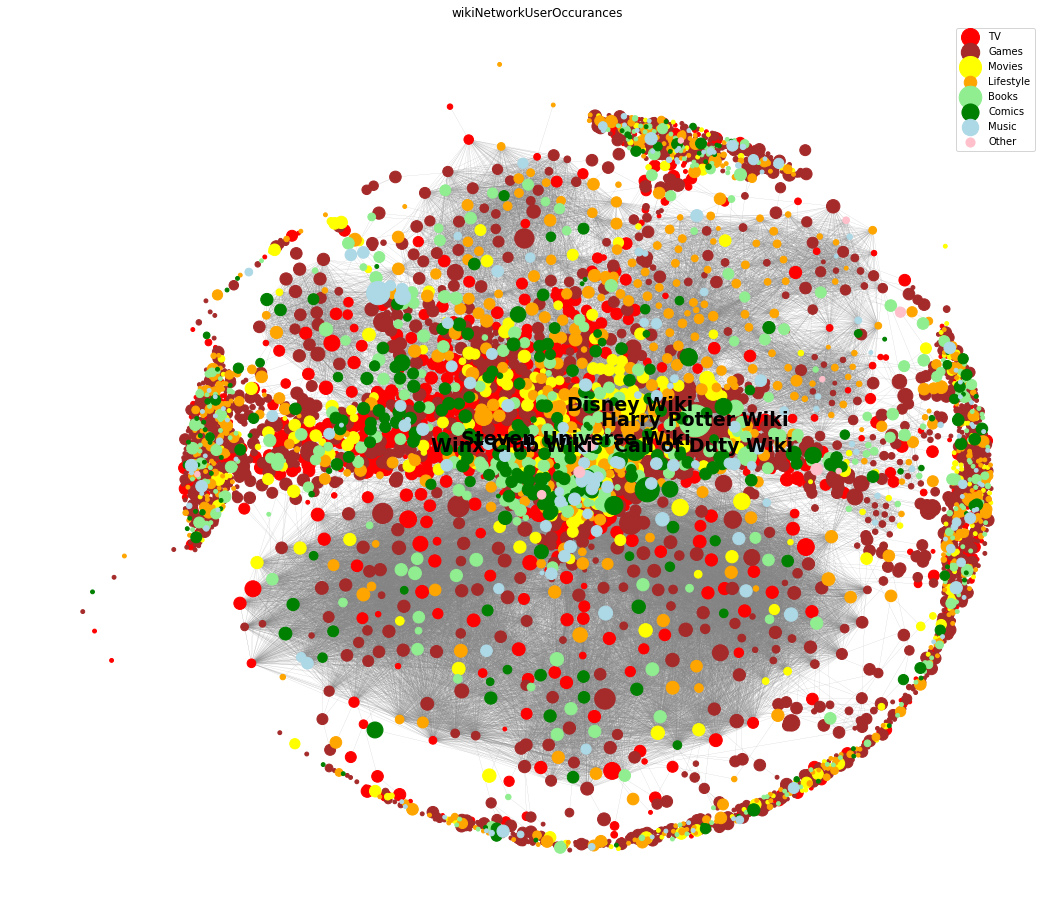

In [19]:
node_size = createNodeSizes(nodeSizeOccurances, hubs) 
for k,v in node_size.items():
    print(k, max(v), min(v), np.average(v))

drawAndSaveGraph(18, 16, G, positions, hubs, node_size, 600, 'wikiNetworkUserOccurances')

The graph above shows that the nodes in the edges are bigger. It shows that the wikis in the edge does not have many degrees, but still some users follow them. This is due to some users only following one wiki. This does not create any edges, though they may still be popular.
* Disney Wiki
* Harry Potter Wiki
* Steven Universe Wiki 
* Winx Club Wiki 
* Call of Duty Wiki 
All nodes with labels on the graph have a size above 600.

The data printed on top of the graph explains the following:
* Hub, 
* Max number of occurances in the user-data within hub, 
* Min number of occurances in the user-data within hub, 
* and average number of occurances in the user-data within hub.

TV 958 2 12.441319107662464
Games 2888 2 13.216142270861834
Movies 491 2 9.2
Lifestyle 602 2 7.882800608828006
Books 247 2 6.030232558139535
Comics 571 2 13.447058823529412
Music 90 2 5.130208333333333
Other 4302 2 469.9


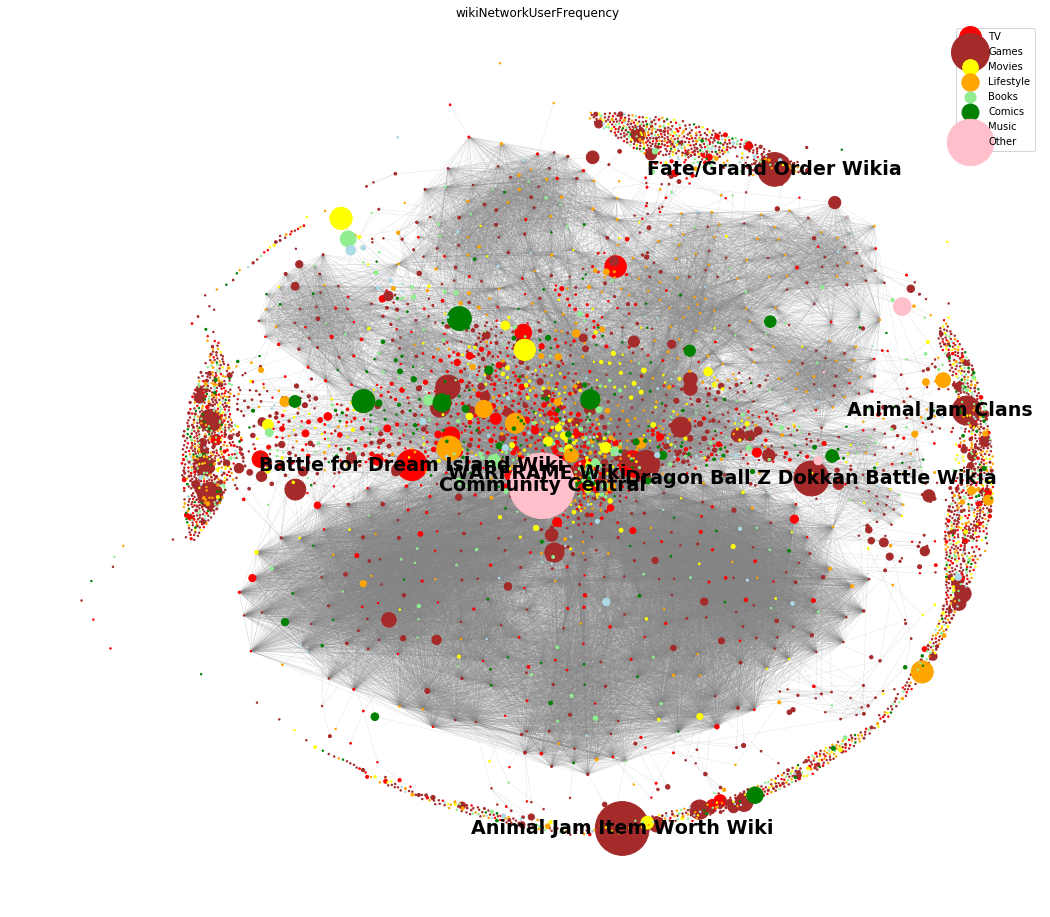

In [20]:
node_size = createNodeSizes(nodeSizeFrequency, hubs) 
for k,v in node_size.items():
    print(k, max(v), min(v), np.average(v))

drawAndSaveGraph(18, 16, G, positions, hubs, node_size, 760, 'wikiNetworkUserFrequency')

The graph seems very different from the others, though this as many reasons. This data is based of the number of active users reported in the data from the API. This data may therefore contain flaws, since the API is not maintained. Though it still gives us an understaing of how the data we are analysing compares to the (perhaps) actual data. The number of times the wikis occures in our user-data (the graph above) should have fit this graph for the dataset to be representing the whole fandom univers better.

## 3 Tools, theory and analysis

Talk about how you've worked with text, including regular expressions, unicode, etc.
Describe which network science tools and data analysis strategies you've used, how those network science measures work, and why the tools you've chosen are right for the problem you're solving.
How did you use the tools to understand your dataset?


I envision Part 3: **Tools, theory and analysis** as the central part of the assignment, where you basically go through the steps in the analysis. So the structure of this part would be something like

* Explain the overall idea
* Analysis step 1
    * explain what you're interested in
    * explain the tool
    * apply the tool
    * discuss the outcome

### 3.1 Degree Distributions

In [21]:
def createHistigram(ylable, xlable, title, fileName, hubsDegree, bins, minimum=0):
    # Create Bin Histogram 
    plt.figure(figsize=(15, 8))  
    plt.style.use('seaborn-deep')
    
    maxDegree = 0
    for v in hubsDegree.values():
        if max(v)>maxDegree:
            maxDegree = max(v)
    bins = np.linspace(minimum, maxDegree, bins)

    plt.hist(list(hubsDegree.values()), 
         bins, 
         label=list(hubsDegree.keys()), 
         histtype='bar',
         edgecolor='black')
    
    plt.rcParams.update({'font.size': 20})
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.title(title)
    plt.ylabel(ylable)
    plt.xlabel(xlable)
    plt.savefig('graphs/'+fileName+'.png')
    plt.show()

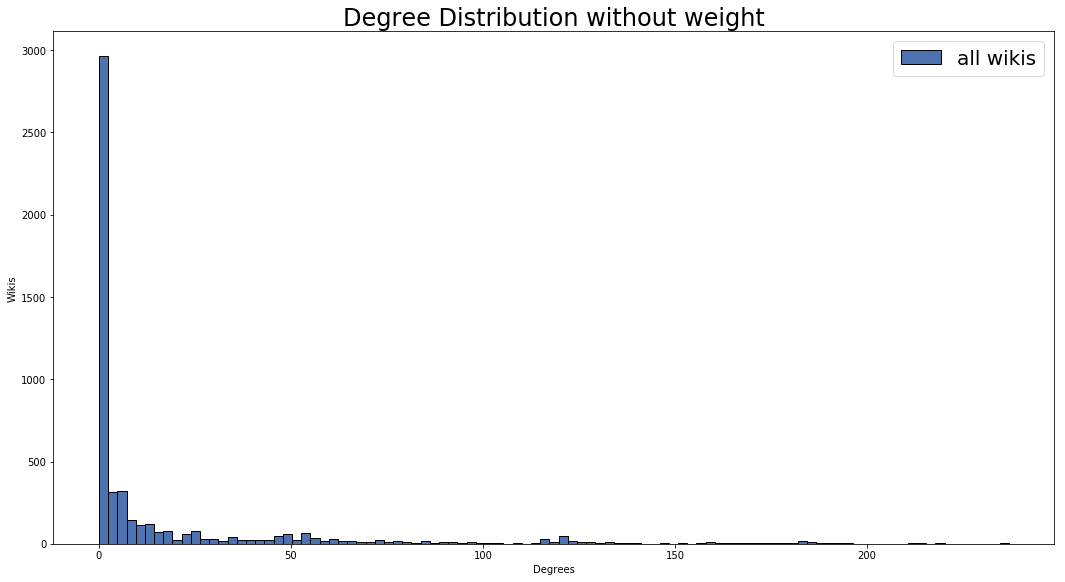

In [22]:
# Data
degrees = {}
degrees['all wikis'] = [val for (node, val) in G.degree()]

createHistigram("Wikis", 
                "Degrees", 
                "Degree Distribution without weight", 
                "wikiDegreeSumHist", 
                degrees,
                100)

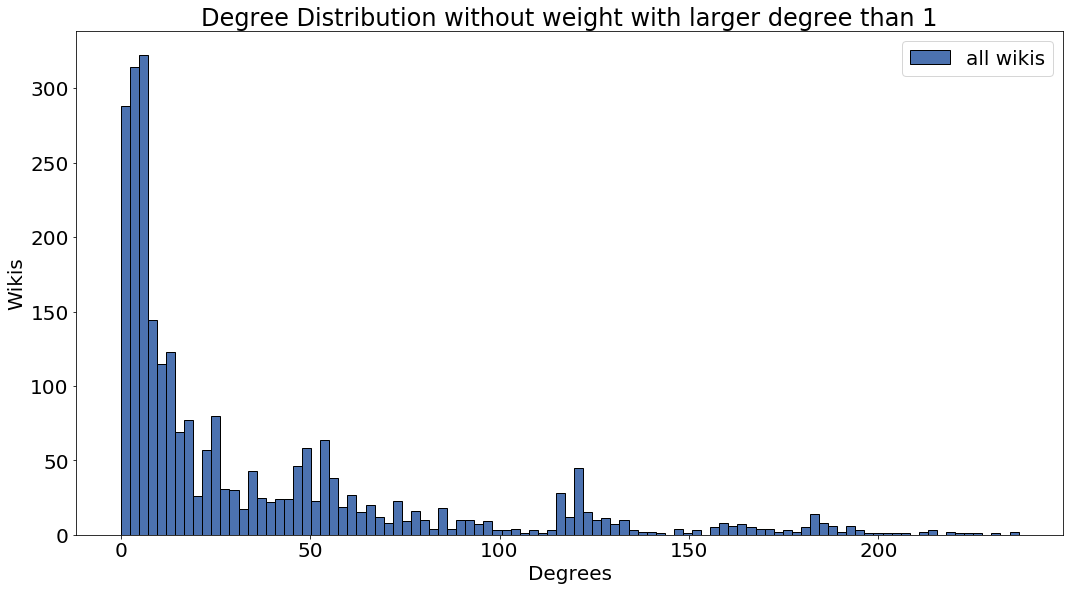

In [23]:
# Data
degrees = {}
degrees['all wikis'] = [val for (node, val) in G.degree() if val>1]

createHistigram("Wikis", 
                "Degrees", 
                "Degree Distribution without weight with larger degree than 1", 
                "wikiDegreelarger1SumHist", 
                degrees,
                100)

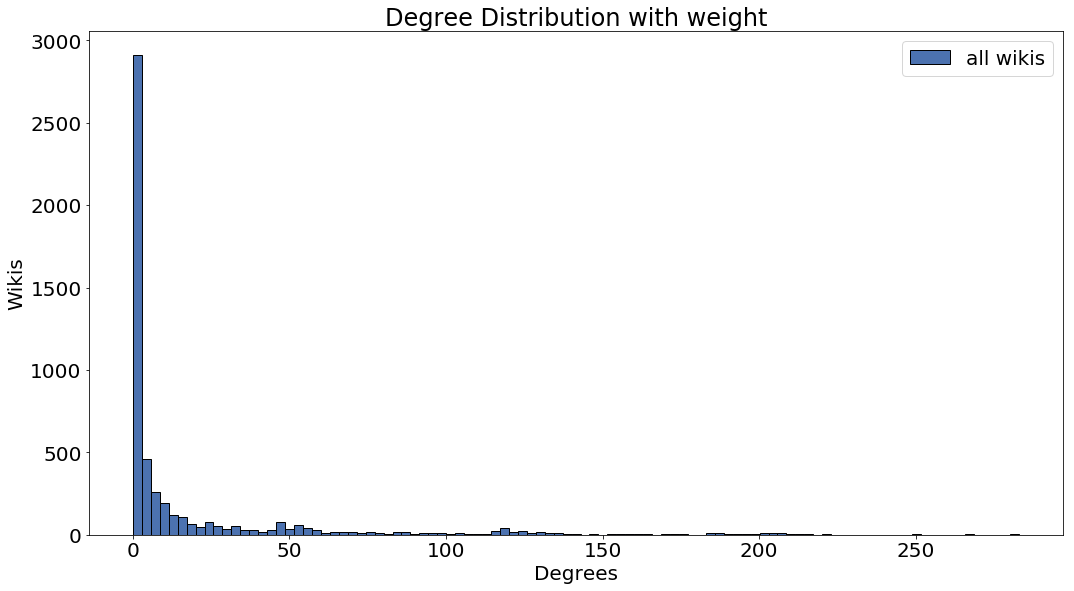

In [24]:
# Data
degrees = {}
degrees['all wikis'] = [val for (node, val) in G.degree(weight='weight')]

createHistigram("Wikis", 
                "Degrees", 
                "Degree Distribution with weight", 
                "wikiDegreeSumWeightHist", 
                degrees,
                100)

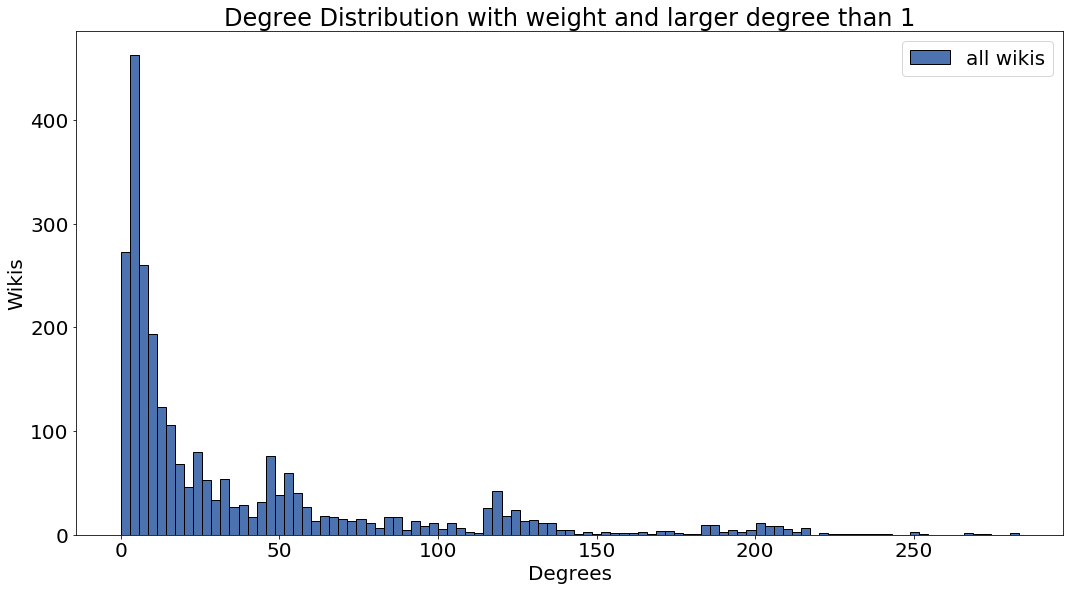

In [25]:
# Data
degrees = {}
degrees['all wikis'] = [val for (node, val) in G.degree(weight='weight') if val>1]

createHistigram("Wikis", 
                "Degrees", 
                "Degree Distribution with weight and larger degree than 1", 
                "wikiDegreeSumlarger1WeightHist", 
                degrees,
                100)

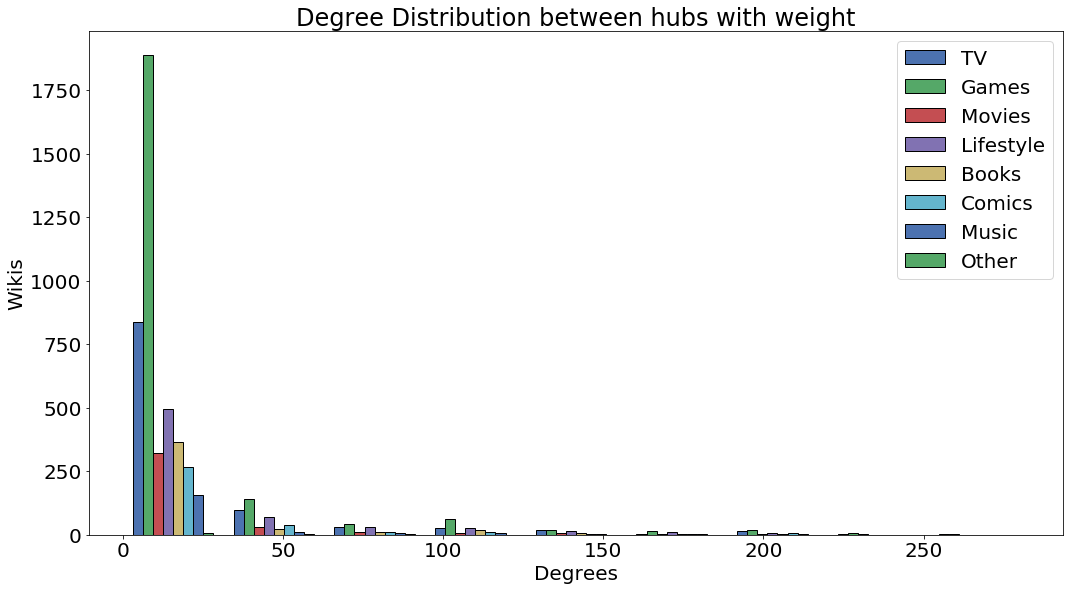

In [26]:
hubsDegree = createNodeSizes(nodeSizeDegree, hubs)
createHistigram("Wikis", 
                "Degrees", 
                "Degree Distribution between hubs with weight", 
                "wikiDegreeWeightHist", 
                hubsDegree, 
                10)

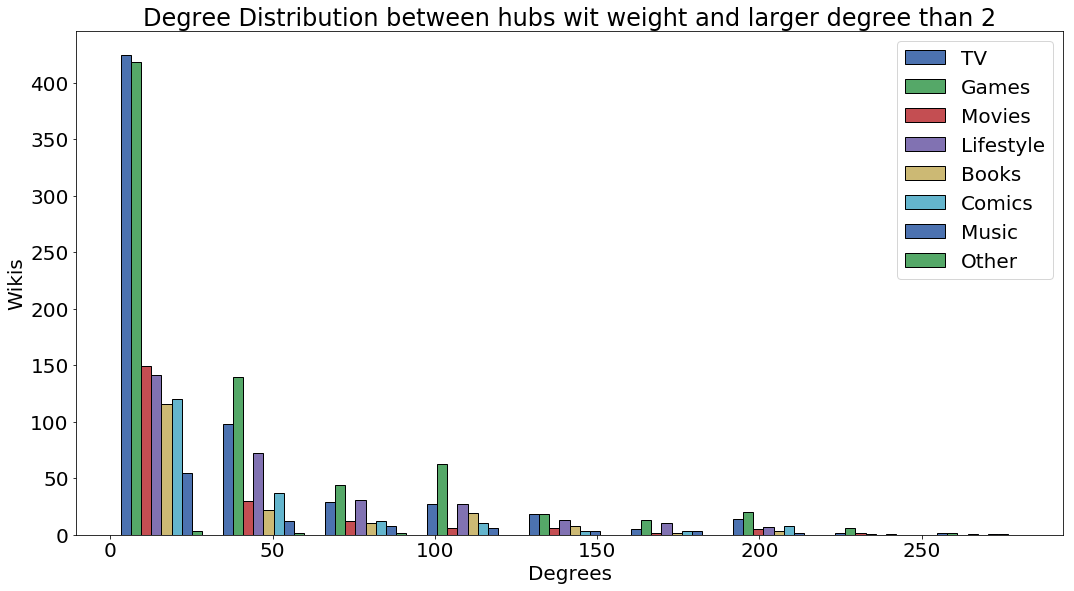

In [27]:
hubsDegreefilter = {}
for k,v in hubsDegree.items():
    hubsDegreefilter[k] = list(filter(lambda a: a > 2, v))

createHistigram("Wikis", 
                "Degrees", 
                "Degree Distribution between hubs wit weight and larger degree than 2", 
                "wikiDegreelarger2WeightHist", 
                hubsDegreefilter, 
                10)

In [28]:
def createCumulativeHistigram(ylable, xlable, title, fileName, hubsDegree):
    
    # Create Cumulative Step Histogram 
    plt.figure(figsize=(12, 3))  
    plt.style.use('seaborn-deep')
    
    maxDegree = 0
    for v in hubsDegree.values():
        if max(v)>maxDegree:
            maxDegree = max(v)
    bins = np.linspace(0, maxDegree, 30)

    plt.hist(list(hubsDegree.values()), 
         bins, 
         label=list(hubsDegree.keys()), 
         histtype='step', 
         cumulative=True)
    #patch.linewidth

    plt.rcParams.update({'font.size': 20})
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.title(title)
    plt.ylabel(ylable)
    plt.xlabel(xlable)
    plt.savefig('graphs/'+fileName+'.png')
    plt.show()

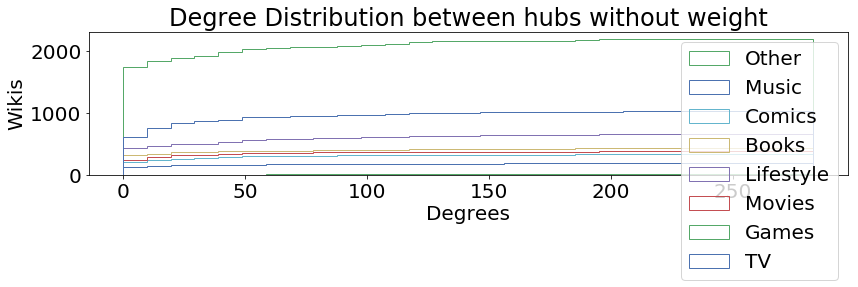

In [29]:
createCumulativeHistigram("Wikis", 
                          "Degrees", 
                          "Degree Distribution between hubs without weight", 
                          "wikiDegreeCumulativeHist", 
                          hubsDegree)

**Log-Log Degree Distribution**

In [30]:
degrees = [val for (node, val) in G.degree(weight='weight')]

Max degree is 283
Min degree is 0


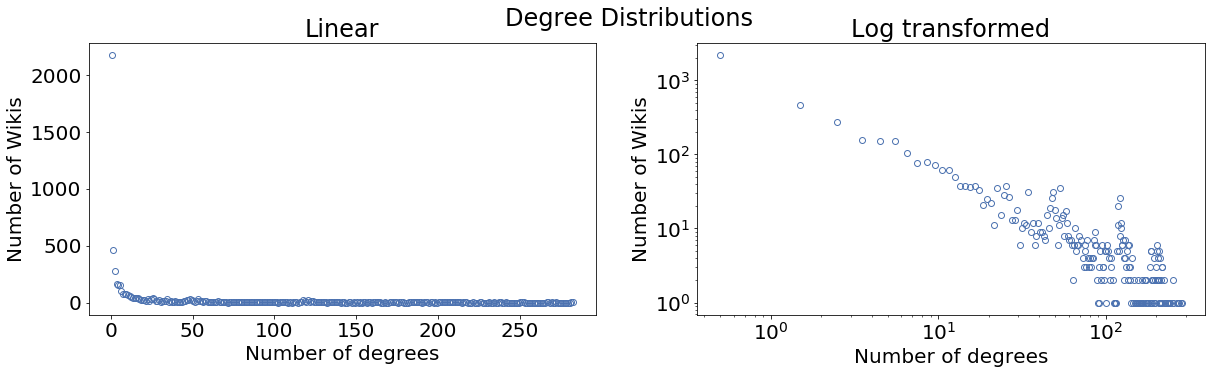

In [31]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 5))

#Find and print min/max
print("Max degree is %s\nMin degree is %s" % (max(degrees), min(degrees)))

# Find bins and hist
hist, binList = np.histogram(degrees, max(degrees))
bins = (binList[1:]+binList[:-1])/2

#Generate linear plot
axs[0].plot(bins,hist, 'o', mfc='none')
axs[0].set_ylabel('Number of Wikis')
axs[0].set_xlabel('Number of degrees')
axs[0].set_title("Linear")


#Generate log-log plot
axs[1].loglog(bins,hist, 'o', mfc='none')
axs[1].set_ylabel('Number of Wikis')
axs[1].set_xlabel('Number of degrees')
axs[1].set_title("Log transformed")

fig.suptitle("Degree Distributions")
plt.savefig('graphs/LogDegreeDistribution.png')
plt.show()


### 3.2 Compare to random Graph

In [32]:
degrees = [val for (node, val) in G.degree()]

n = len(G.nodes())
k = int(round(np.average(degrees)))
m = 3
seed = None

# Create Randam graph
G_random = nx.watts_strogatz_graph(n,k , 1)
degrees_random = [val for (node, val) in G_random.degree(weight='weight')]

# Create BA Graph
G_ba= nx.barabasi_albert_graph(n, m, seed=seed)
degrees_ba = [val for (node, val) in G_ba.degree(weight='weight')]

Our: Number of nodes 5238, Number of edges 45389, Max degree is 237, Min degree is 0
BA:  Number of nodes 5238, Number of edges 15705, Max degree is 216, Min degree is 3
Ran: Number of nodes 5238, Number of edges 41904, Max degree is 28, Min degree is 8


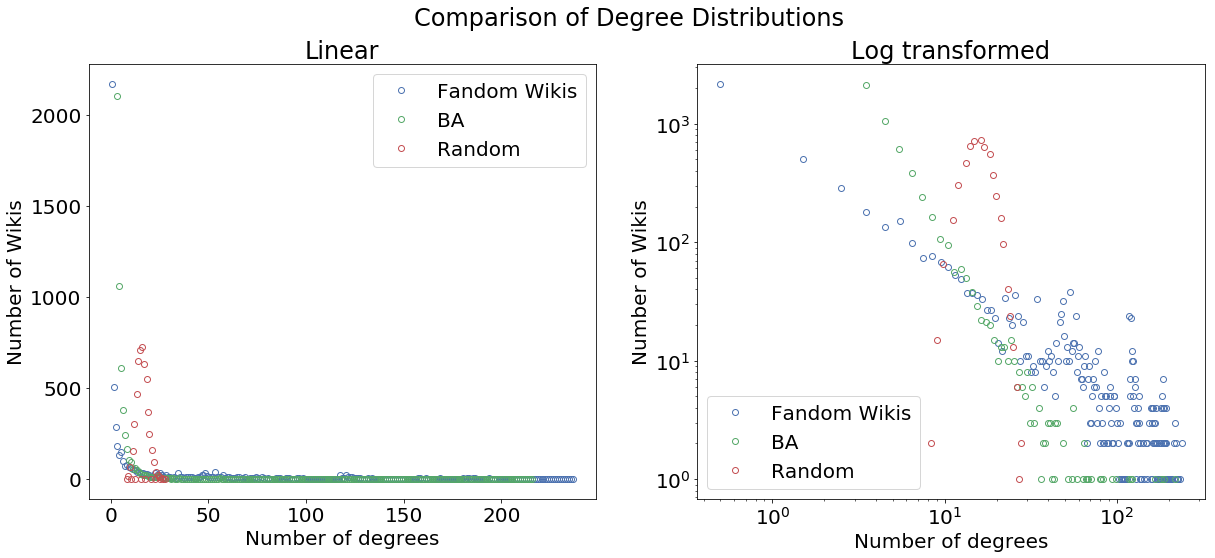

In [33]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))

#Find and print min/max
print("Our: Number of nodes %s, Number of edges %s, Max degree is %s, Min degree is %s" % 
      (len(G.nodes()), len(G.edges()), max(degrees), min(degrees)))
print("BA:  Number of nodes %s, Number of edges %s, Max degree is %s, Min degree is %s" % 
      (len(G_ba.nodes()), len(G_ba.edges()), max(degrees_ba), min(degrees_ba)))
print("Ran: Number of nodes %s, Number of edges %s, Max degree is %s, Min degree is %s" % 
      (len(G_random.nodes()), len(G_random.edges()), max(degrees_random), min(degrees_random)))

#### Our graph ###
hist, binList = np.histogram(degrees, max(degrees))
bins = (binList[1:]+binList[:-1])/2

dot1, = axs[0].plot(bins,hist, 'o', mfc='none')
dotlog1, = axs[1].loglog(bins,hist, 'o', mfc='none')

#### Random graph ###
hist, binList = np.histogram(degrees_ba, max(degrees_ba))
bins = (binList[1:]+binList[:-1])/2

dot2, = axs[0].plot(bins,hist, 'o', mfc='none')
dotlog2, = axs[1].loglog(bins,hist, 'o', mfc='none')


#### BA graph ###
hist, binList = np.histogram(degrees_random, max(degrees_random))
bins = (binList[1:]+binList[:-1])/2

dot3, = axs[0].plot(bins,hist, 'o', mfc='none')
dotlog3, = axs[1].loglog(bins,hist, 'o', mfc='none')


# finishing touches
axs[0].legend([dot1, dot2, dot3], ["Fandom Wikis", "BA","Random"])
axs[0].set_ylabel('Number of Wikis')
axs[0].set_xlabel('Number of degrees')
axs[0].set_title("Linear")

axs[1].legend([dotlog1, dotlog2, dotlog3], ["Fandom Wikis", "BA","Random"])
axs[1].set_ylabel('Number of Wikis')
axs[1].set_xlabel('Number of degrees')
axs[1].set_title("Log transformed")

fig.suptitle("Comparison of Degree Distributions")
plt.savefig('graphs/DegreeDistributionComparison.png')
plt.show()


### 3.3 Shortest Path Length

In [34]:
connected_graphs = []
for i in range(1,7):
    connected_graphs.append([c for c in nx.connected_component_subgraphs(G) if len(c)==i])
connected_graphs.append([c for c in nx.connected_component_subgraphs(G) if len(c)>6])
connected_graphs

print("The overall network contains:")
for graphList in connected_graphs:
    print(" - %s nodes per graph, total amount of graphs %s, with average shortest path len %s" % 
        (len(graphList[0].nodes()), #np.average([len(g.nodes()) for g in graphList]),
         len(graphList),
         np.average([nx.average_shortest_path_length(x) for x in graphList])))

print("The average shortest path length for graph BA (nodes: %s) is %s" % 
      (len(G_ba.nodes()),
       nx.average_shortest_path_length(G_ba)))
print("The average shortest path length for graph Random (nodes: %s) is %s" %
      (len(G_random.nodes()),
       nx.average_shortest_path_length(G_random)))

The overall network contains:
 - 1 nodes per graph, total amount of graphs 2172, with average shortest path len 0.0
 - 2 nodes per graph, total amount of graphs 94, with average shortest path len 1.0
 - 3 nodes per graph, total amount of graphs 19, with average shortest path len 1.1929824561403508
 - 4 nodes per graph, total amount of graphs 4, with average shortest path len 1.5
 - 5 nodes per graph, total amount of graphs 3, with average shortest path len 1.0999999999999999
 - 6 nodes per graph, total amount of graphs 1, with average shortest path len 1.0
 - 2784 nodes per graph, total amount of graphs 1, with average shortest path len 3.604902868813527
The average shortest path length for graph BA (nodes: 5238) is 4.041407866589121
The average shortest path length for graph Random (nodes: 5238) is 3.4115608219279756


### 3.4 Centralities

In [35]:
current_time = time.time()
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
print(hub, time.time()-current_time)
betweenness_centrality

TV 470.6887969970703


{'Radio-TV Broadcast History': 0.0002552271871150221,
 '中文電視大典': 0.00020587560710842677,
 'Greek TV Series Wiki': 0.00019132931015306378,
 'SM:tv Live Wiki': 0.0,
 'Oz TV Wiki': 0.00011321579736954063,
 'Renesanční Království Wiki': 0.0,
 '电影维基 Wikia': 0.0,
 'V: The Visitors Return MUSH Wiki': 0.0,
 'Blue Bloods Wiki': 0.00020512663060583364,
 'Wiki Los Super Once': 0.0,
 'Fictionaltvstations Wiki': 1.9579942759954288e-05,
 'Blue Peter Wiki': 0.0006601258254732311,
 'Logopedia Wiki': 0.0,
 'Iptv Wiki': 0.00020692893665468423,
 'Cardfight!! Vanguard Fanon Wiki': 0.0,
 'Indie Game Guide': 0.0005988892126477851,
 'Paper Computer Games': 0.0,
 "Tony Hawk's Games Wiki": 0.0,
 'TEW Games Wiki': 0.0003380152497425132,
 'Game Shows Wiki': 8.22791440581463e-05,
 'LEGO Games Wiki': 0.00010599305111522794,
 'Armor Games Wiki': 1.0276580097723987e-07,
 'Card Game Wiki': 0.0008561575401707235,
 'Techno Games Wiki': 4.728804139469464e-05,
 'Humongous Entertainment Games Wiki': 7.67998816556222e-05,


TV 440.3776808852831 0.0 21.52636491432333
Games 459.6927198236764 0.0 9.699963019538211
Movies 769.2852209667215 0.0 20.159187743135632
Lifestyle 310.69886204077 0.0 13.701962995089428
Books 513.6773471062513 0.0 13.15194641964951
Comics 430.3785947357689 0.0 20.499131885848286
Music 128.22481864535914 0.0 10.60503348362006
Other 59.218576788931806 0.0 13.634389235062176


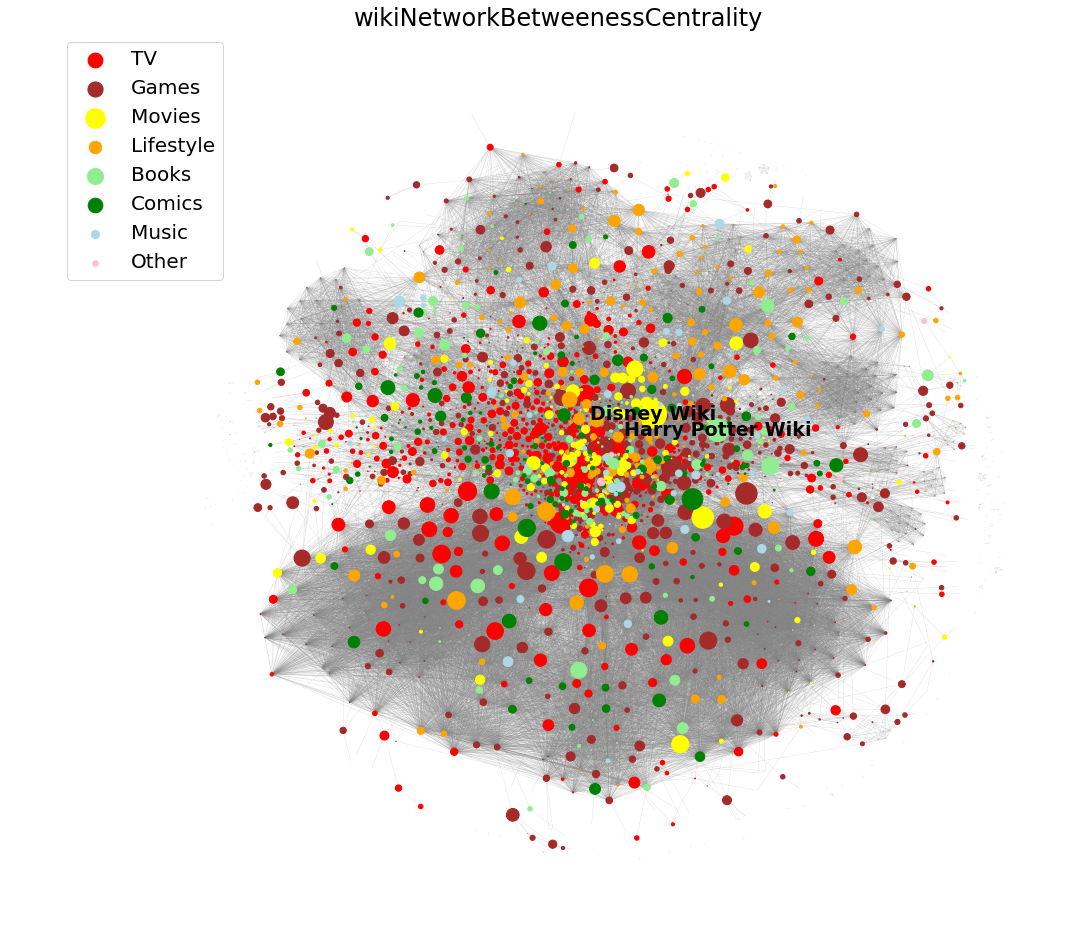

In [36]:
# Calculate node size according to Betweeness Centrality
def nodeSizeBetweennessCentrality(nodeList, betweenness_centrality):
    return [betweenness_centrality[node]*100000 for node in nodeList]

node_size = createNodeSizes(nodeSizeBetweennessCentrality, hubs, betweenness_centrality) 

for k,v in node_size.items():
    print(k, max(v), min(v), np.average(v))

drawAndSaveGraph(18, 16, G, positions, hubs, node_size, 500, 'wikiNetworkBetweenessCentrality')

TV 583.8202703367576 -2.3333826496949972e-14 19.02646778597872
Games 582.0236278312386 -3.309424096711422e-14 15.211996865291363
Movies 460.4773901879501 -1.0119424932083381e-14 16.749027153005663
Lifestyle 477.11683063426625 -1.1134529697298906e-14 16.02802992035239
Books 447.31573020541225 -1.902889252251137e-14 15.102687001699076
Comics 450.55012085374017 -8.506087371124708e-15 23.506443487930685
Music 583.0484961669276 -1.3188562140253777e-14 21.54424265231496
Other 9.936471663921907 -4.381305765585709e-16 3.3806648948992413


/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:853: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


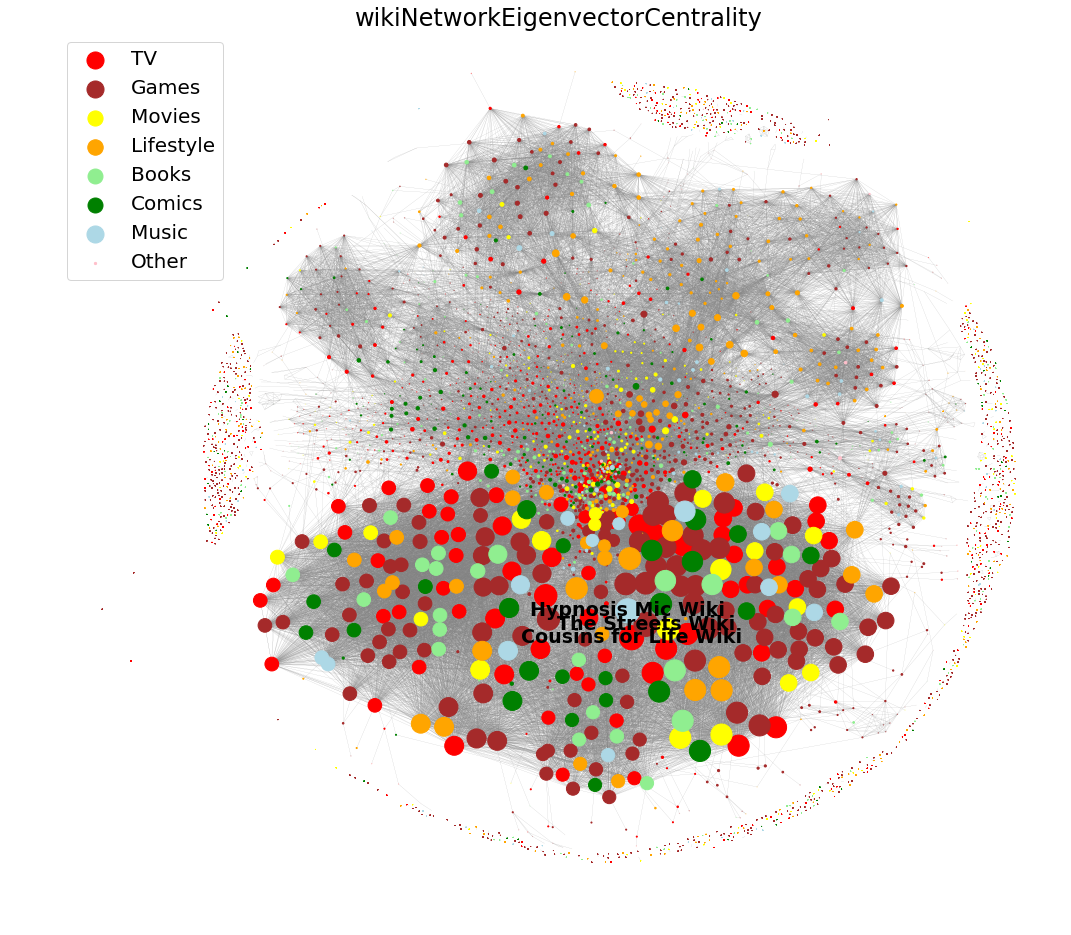

In [37]:
# Calculate node size according to Eigenvector Centrality
def nodeSizeEigenvectorCentrality(nodeList):
    eigenvector_centrality = nx.eigenvector_centrality_numpy(G, weight='weight')
    return [eigenvector_centrality[node]*5000 for node in nodeList]


node_size = createNodeSizes(nodeSizeEigenvectorCentrality, hubs) 

for k,v in node_size.items():
    print(k, max(v), min(v), np.average(v))

drawAndSaveGraph(18, 16, G, positions, hubs, node_size, 516, 'wikiNetworkEigenvectorCentrality')

### 3.5 Communities + matrix

Modularity using the Louvain algorithm: 0.6480109424807863


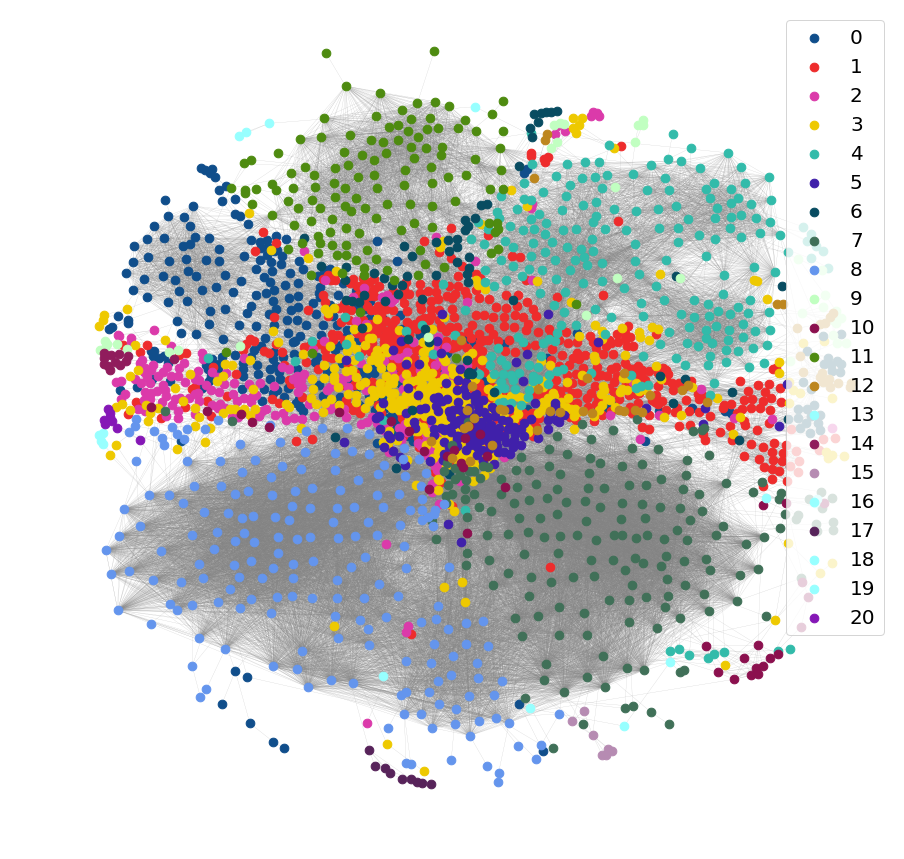

In [38]:
G_connected = connected_graphs[6][0]

#Community partitions
partition = cm.best_partition(G_connected)

#Modularity
mod = cm.modularity(partition, G_connected)
print('Modularity using the Louvain algorithm:', mod)

fig = plt.figure(figsize=(15, 15))

colors = np.asarray(['#104E8B','#EE2C2C','#db3aAA','#EEC900','#32BBAA',
                     '#4020AA','#084c61','#407058','#6495ED','#C1FFC1',
                     '#8b104e','#4e8b10','#bd861e','#901c5c','#b68bb2',
                     '#57235a','#8517b6','#8f7cce','#5628ee','#708dae',
                     '#70a6ae','#26b0a5','#0f9440','#948e0f','#dd8e3f'])
i = 0
for com in set(partition.values()):
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    
    nodes = [nodes for nodes in list_nodes]

    if len(list_nodes)>5: 
        color = colors[i]
        i += 1
    else: 
        color = "#97FFFF"

    nx.draw_networkx_nodes(G_connected, positions, nodes, node_size = 75, node_color = color, label=com)

plt.legend(numpoints = 1)
nx.draw_networkx_edges(G_connected, positions, width = 0.2, alpha=0.5, edge_color='gray')
plt.axis('off')
plt.savefig('graphs/communities.png')
plt.show()

In [39]:
#  Define a community size function to sort the community by size computing the confusion matrix.
def community_Size(com):
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    return len(list_nodes)

In [40]:
D = np.zeros((len(hubs), len(set(partition.values()))),dtype = int) # Define the matrix
sorted_partition = sorted(set(partition.values()), key = community_Size, reverse =True)

i=0 # Set a count
for com in sorted_partition:  # Go through the partition
    j = 0
    hub_node = {}
    for key in hubs.keys():
        hub_node[key] = [node for node in partition.keys() 
                           if partition[node] == com and key in G.node[node]["hub"]]

        D[j,i]=len(hub_node[key]) # line 0 corresponds to the republicans
        j+=1
    i+=1

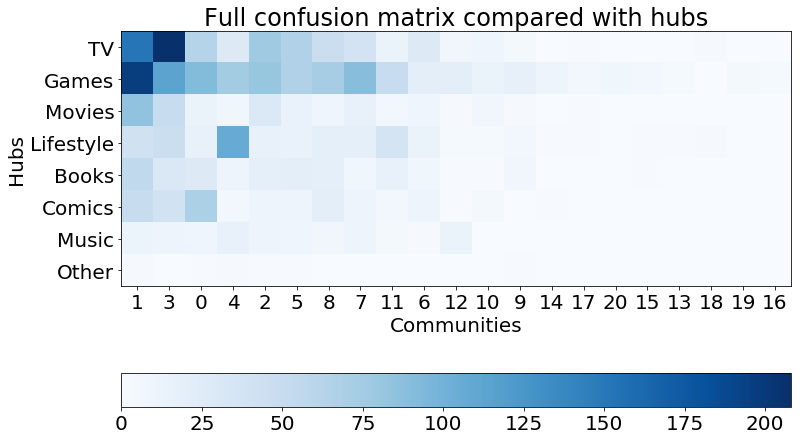

In [41]:
fig = plt.figure(figsize=(12, 8))

im= plt.imshow(D, cmap=pltcm.Blues)
plt.title("Full confusion matrix compared with hubs")
plt.yticks([i for i in range(len(hubs.keys()))], hubs.keys(), rotation='horizontal')
plt.xticks([i for i in range(len(sorted_partition))], sorted_partition, rotation='horizontal')
plt.ylabel("Hubs")
plt.xlabel("Communities")

fig.colorbar(im, orientation = "horizontal", pad=0.2)
plt.savefig('graphs/Matrix_hub.png')
plt.show()

In [42]:
#set([G.node[n]['topic'] for n in G.nodes()])

In [43]:
D_hub = np.zeros((len(hubs),1)) # Define the matrix

i=0 # Set a count
hub_node={}
for h in hubs.keys():
    hub_node[h] = [node for node in G_connected.nodes() 
                           if h in G_connected.node[node]["hub"]]

    D_hub[i,0]=len(hub_node[h]) # line 0 corresponds to the republicans
    i+=1

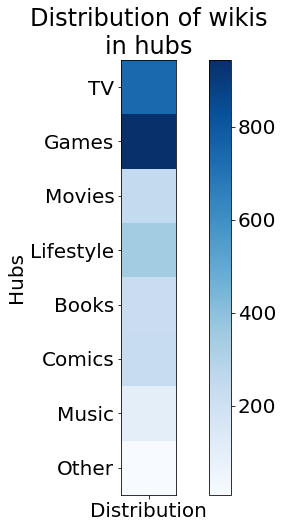

In [44]:
fig = plt.figure(figsize=(12, 8))
im= plt.imshow(D_hub, cmap=pltcm.Blues)
plt.title("Distribution of wikis\nin hubs")
plt.yticks([i for i in range(len(hubs.keys()))], hubs.keys(), rotation='horizontal')
plt.xticks([0], ['Distribution'], rotation='horizontal')
plt.ylabel("Hubs")

fig.colorbar(im, orientation = "vertical", pad=0.05)
plt.savefig('graphs/Matrix_hub_distribution.png')
plt.show()

In [45]:
topics = [t for t in set(activeDataSet['topic']) if str(t) != 'nan']
topics.append('')

D = np.zeros((len(topics), len(set(partition.values()))),dtype = int) # Define the matrix

i=0 # Set a count
for com in sorted_partition:  # Go through the partition
    
    j = 0
    topic_node = {}
    for t in topics:
        if t != '':
            topic_node[t] = [node for node in partition.keys() 
                               if partition[node] == com and t in G.node[node]["topic"]]
        else:
            topic_node[t] = [node for node in partition.keys() 
                               if partition[node] == com and t == G.node[node]["topic"]]

        D[j,i]=len(topic_node[t]) # line 0 corresponds to the republicans
        j+=1
    i+=1

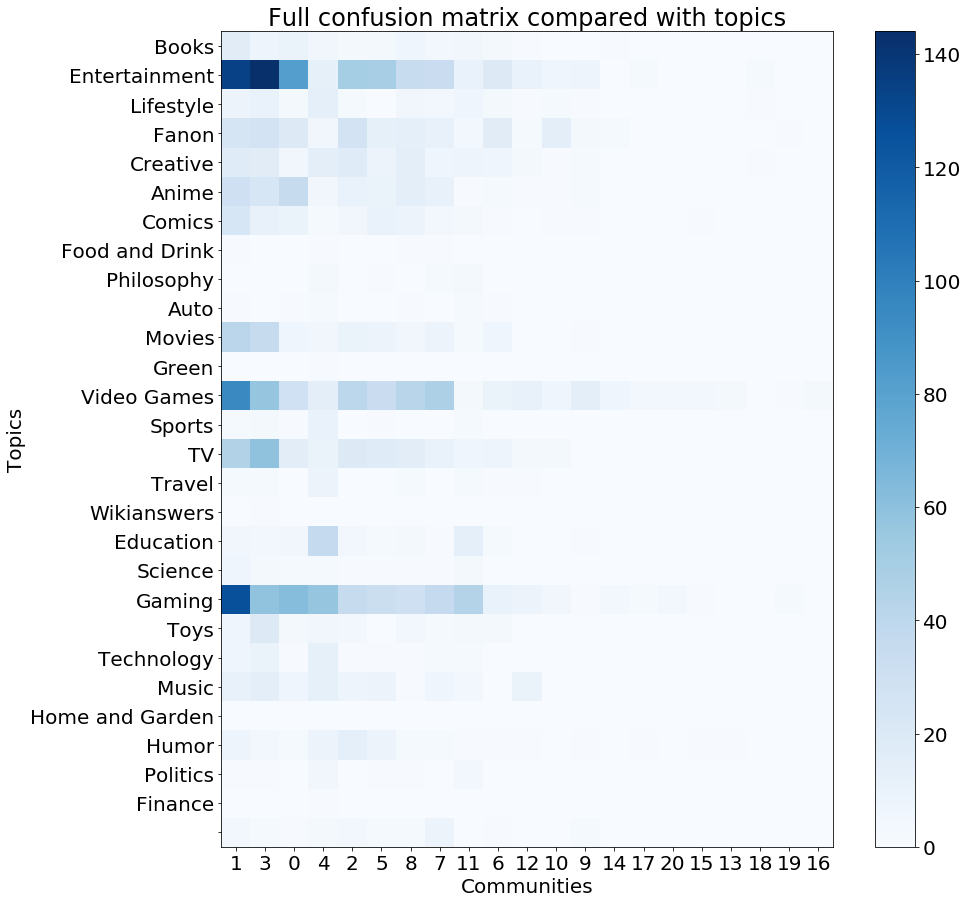

In [46]:
fig = plt.figure(figsize=(15, 15))

im= plt.imshow(D, cmap=pltcm.Blues)
plt.title("Full confusion matrix compared with topics")
plt.yticks([i for i in range(len(topics))], topics, rotation='horizontal')
plt.xticks([i for i in range(len(sorted_partition))], sorted_partition, rotation='horizontal')
plt.ylabel("Topics")
plt.xlabel("Communities")

fig.colorbar(im, orientation = "vertical", pad=0.05)
plt.savefig('graphs/Matrix_topic.png')
plt.show()

In [47]:
D_topic = np.zeros((len(topics),1)) # Define the matrix

i=0 # Set a count
topic_node = {}
for t in topics:
    if t != '':
        topic_node[t] = [node for node in G_connected.nodes() 
                            if t in G_connected.node[node]["topic"]]
    else:
        topic_node[t] = [node for node in G_connected.nodes() 
                            if t == G_connected.node[node]["topic"]]

    D_topic[i,0]=len(topic_node[t]) # line 0 corresponds to the republicans
    i+=1

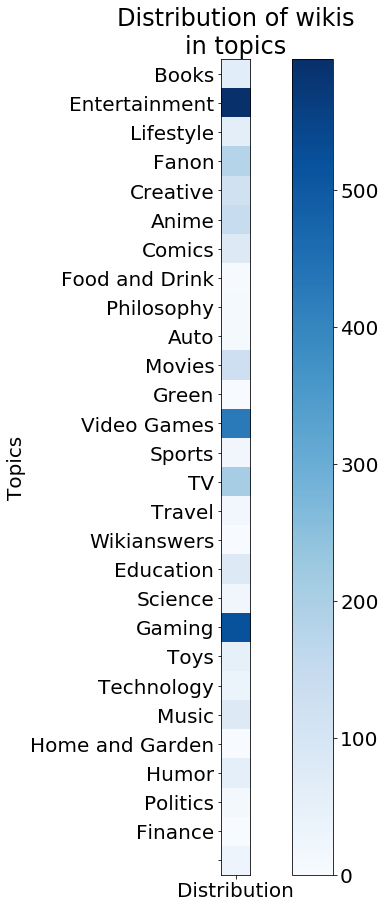

In [48]:
fig = plt.figure(figsize=(15, 15))

im= plt.imshow(D_topic, cmap=pltcm.Blues)
plt.title("Distribution of wikis\nin topics")
plt.yticks([i for i in range(len(topics))], topics, rotation='horizontal')
plt.xticks([0], ['Distribution'], rotation='horizontal')
plt.ylabel("Topics")

fig.colorbar(im, orientation = "vertical", pad=0.05)
plt.savefig('graphs/Matrix_topic_distribution.png')
plt.show()

### 3.6 TF-IDF

In [49]:
# Divide data into hubs
hub_articles_wiki = {}
hub_keys = ['TV', 'Music', 'Lifestyle', 'Books', 'Movies', 'Other', 'Games', 'Comics']

## Get Article Data ##
for dataPath in glob.glob("data/articles/text_from_wikis/*.json"):
    hub = 'Not found'
    
    # find files hub
    for h in hub_keys:
        if h in dataPath:
            hub = h
    
    # initialise directory
    if hub not in hub_articles_wiki:
        print('\n', dataPath)
        hub_articles_wiki[hub] = {}
    
    # load file
    with open(dataPath) as f:
         text = json.loads(f.read())
    
    # merge dirctory wiki data into the hub directory.
    hub_articles_wiki[hub].update(text)
    
    # control correct/all data
    print(len(text), end=', ')


 data/articles/text_from_wikis/Books-articles-part-1.json
250, 183, 
 data/articles/text_from_wikis/Comics-articles-part-1.json
250, 104, 
 data/articles/text_from_wikis/Games-articles-part-1.json
250, 87, 250, 250, 250, 250, 250, 250, 250, 198, 
 data/articles/text_from_wikis/Lifestyle-articles-part-1.json
250, 250, 174, 
 data/articles/text_from_wikis/Movies-articles-part-1.json
250, 158, 
 data/articles/text_from_wikis/Music-articles-part-1.json
192, 
 data/articles/text_from_wikis/Other-articles-part-1.json
10, 
 data/articles/text_from_wikis/TV-articles-part-1.json
250, 250, 250, 241, 88, 

In [50]:
### Sort data ###

# List of stop words, punctuation marks and unicode hex characters
encodings = ['\xef', '\xe2', '\xcc', '\xe3', '\xf0', 'i\xe2', 't\xe2', 'a\xe2', 'it\xe2', 's\xe2', 'we\xe2', 'and\xe2', 'the\xe2']
uninteresting_common_words = ['one', 'also', 'first', 'time', 'however', 'wiki', 'wikia', 'back']
stop_punct = set(stopwords.words('english')
                 + list(string.punctuation) 
                 + get_stop_words('en')
                 + encodings
                 + uninteresting_common_words)

# Tokenize the text in both files and filter the stopwords, punctuation marks and unicode hex characters
tokenizer = RegexpTokenizer(r'\w+')

# Filter data
hub_articles_wiki_filtered = {}
for k,v in hub_articles_wiki.items():
    # initialize filter
    if k not in hub_articles_wiki_filtered:
            hub_articles_wiki_filtered[k] = {}
    
    # find 25 wikis with wordcount abouve 500 in every hub
    counter = 0
    for wiki,text in v.items():
        
        # only take 25 wikis
        if counter == 25:
            break
        
        # Ensure wordcount greater than 500
        if len(text)<500:
            continue
        
        # remove links and make lower case
        regx_list = ['(http|https):\/\/\w*.\w*\/\w*', '\d']
        for regx in regx_list:
            text = re.sub(regx, '', text).lower()
        
        # tokenize data
        filter_hub = tokenizer.tokenize(text)
        
        # remove words with length less than 3 and stop words, etc.
        hub_articles_wiki_filtered[k][wiki] = [word for word in filter_hub if word not in stop_punct and len(word)>3]
        
        # add counter
        counter += 1
    
    #First 1 element for the first 3 wikis in the filtered tokenized list for every hub
    print(k, end=' ')
    [print(hub_articles_wiki_filtered[k][wiki][:1], end=' ') for wiki in list(hub_articles_wiki_filtered[k].keys())[:3]]
    print(len(hub_articles_wiki_filtered[k]))

Books ['percy'] ['scary'] ['garth'] 25
Comics ['image'] ['irish'] ['comics'] 25
Games ['renesanční'] ['visitors'] ['cardfight'] 25
Lifestyle ['otherkin'] ['brother'] ['psychology'] 25
Movies ['right'] ['comics'] ['dragonology'] 25
Music ['music'] ['christian'] ['electronic'] 25
Other ['soul'] ['community'] ['centrum'] 4
TV ['radio'] ['greek'] ['live'] 25


In [51]:
### Merge wikis together to hubs ###
hub_articles = {}

for k,v in hub_articles_wiki_filtered.items():
    if k not in hub_articles:
        hub_articles[k] = []
    for wiki_text in list(v.values())[:10]:
        hub_articles[k] = hub_articles[k]+wiki_text
    print(k, len(hub_articles[k]))

Books 56301
Comics 69443
Games 50872
Lifestyle 113368
Movies 483763
Music 65298
Other 17280
TV 105655


Methods to calculate TF / IDF / TF-IDF

In [52]:
def calculateTF(wordList):
    FD = nltk.FreqDist(wordList)
    TF = []
    n =  float(len(wordList))
    for i in FD.most_common(len(FD)):
        TF.append((i[0], float(i[1])/n))
    return TF

In [53]:
def calculateIDF(documentList):
    all_words = []
    for dokument in documentList.values():
        all_words = all_words + dokument
        all_words = list(set(all_words))
    
    print('All words in every wiki: ',len(all_words))
    
    IDF = []
    n = math.log(float(len(documentList)))
    for word in all_words:
        contains = sum(1 for dokument in documentList.values() if word in set(dokument))
        IDF.append((word, (n / float(1 + contains))))
        if len(IDF) % 500 == 0:
            print(len(IDF), end=', ')

    IDF.sort(key=lambda tup: tup[1],reverse=True)
    return IDF

In [54]:
def calculateTF_IDF(TF_List, IDF_List):
    TF_IDF = {}
    for TF in TF_List:
        IDF = [idf[1] for idf in IDF_List if idf[0] == TF[0]]
        TF_IDF[TF[0]] = float(TF[1])*float(IDF[0])
    #TF_IDF.sort(key=lambda tup: tup[1],reverse=True)
    return TF_IDF

#### TF-IDF for hub:
hub = document

In [55]:
# hub = document
TF_hub = {}

#Calculates the TF for each word
for k,v in hub_articles.items():
    TF_hub[k] = calculateTF(v)
    
    #The 3 words with the highest term frequency for both Democratic and Republican tweets:
    print(k, len(hub_articles[k]), len(TF_hub[k]))
    print(' ', TF_hub[k][:3])

Books 56301 11124
  [('roland', 0.00760199641214188), ('book', 0.004618035203637591), ('like', 0.004475941812756434)]
Comics 69443 11856
  [('mark', 0.01474590671485967), ('comics', 0.006120127298647812), ('comic', 0.005256109327074003)]
Games 50872 10413
  [('game', 0.007626985375058972), ('power', 0.005169838024846674), ('unit', 0.004383550872778739)]
Lifestyle 113368 25107
  [('states', 0.02197269070637217), ('united', 0.021487544986239504), ('family', 0.004692682238374144)]
Movies 483763 28615
  [('jedi', 0.010740796629754653), ('skywalker', 0.007962576716284628), ('sith', 0.005880978909093916)]
Music 65298 12476
  [('music', 0.010260651168489081), ('band', 0.006891482128089681), ('album', 0.006171705105822537)]
Other 17280 5998
  [('chocolate', 0.019386574074074073), ('milk', 0.008912037037037038), ('pages', 0.0050347222222222225)]
TV 105655 12954
  [('show', 0.008347924849746818), ('game', 0.006473900903885287), ('brother', 0.005764043348634707)]


In [56]:
# hub = document

#Calculates the IDF for each word
IDF_hub = calculateIDF(hub_articles)

All words in every wiki:  62840
500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500, 15000, 15500, 16000, 16500, 17000, 17500, 18000, 18500, 19000, 19500, 20000, 20500, 21000, 21500, 22000, 22500, 23000, 23500, 24000, 24500, 25000, 25500, 26000, 26500, 27000, 27500, 28000, 28500, 29000, 29500, 30000, 30500, 31000, 31500, 32000, 32500, 33000, 33500, 34000, 34500, 35000, 35500, 36000, 36500, 37000, 37500, 38000, 38500, 39000, 39500, 40000, 40500, 41000, 41500, 42000, 42500, 43000, 43500, 44000, 44500, 45000, 45500, 46000, 46500, 47000, 47500, 48000, 48500, 49000, 49500, 50000, 50500, 51000, 51500, 52000, 52500, 53000, 53500, 54000, 54500, 55000, 55500, 56000, 56500, 57000, 57500, 58000, 58500, 59000, 59500, 60000, 60500, 61000, 61500, 62000, 62500, TV 

AttributeError: 'list' object has no attribute 'values'

The error above is a print statment in the end. It has now been removed, though due to the calculation time, there was nt time to re-run the code. However, it does not influence the result as the code got to run and save the data before the error. 

In [57]:
# hub = document
TF_IDF = {}

#Calculates the TF-IDF for each word
for k,v in TF_hub.items():
    TF_IDF[k] = calculateTF_IDF(v, IDF_hub)
    
    print(k, len(TF_IDF[k]))
    try:
        [print(' ', TF_IDF[k][i]) for i in list(TF_IDF[k].keys())[:2]]
    except:
        print('Debug')
    

Books 11124
  0.002634651189851482
  0.001066992693709323
Comics 11856
  0.0034070278880683146
  0.0021210744908628423
Games 10413
  0.0017622078029646876
  0.0011944862169580228
Lifestyle 25107
  0.005076769537479193
  0.0049646770747889665
Movies 28615
  0.004466971740529319
  0.004139428200663718
Music 12476
  0.0023707138093824382
  0.0015922704689882046
Other 5998
  0.005759035354354704
  0.002647437147972013
TV 12954
  0.0019287801910427705
  0.0014957887195841894


Books


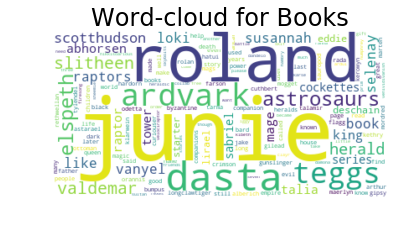

Comics


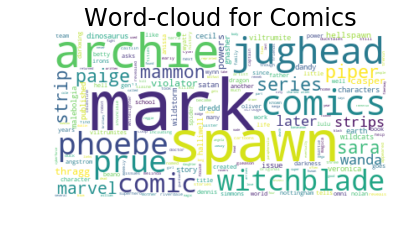

Games


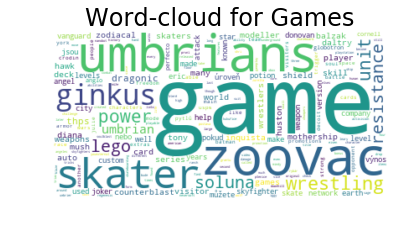

Lifestyle


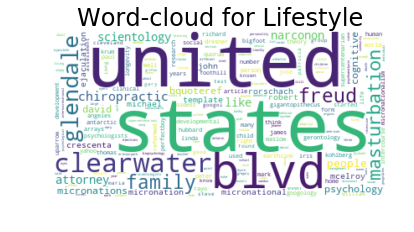

Movies


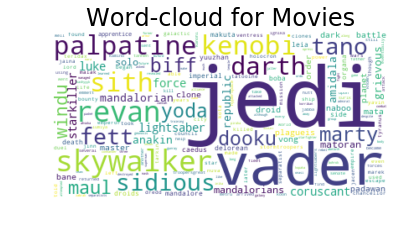

Music


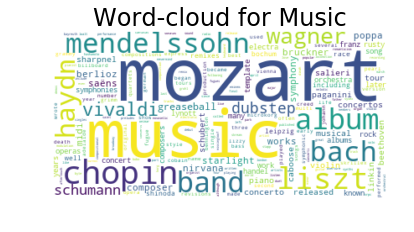

Other


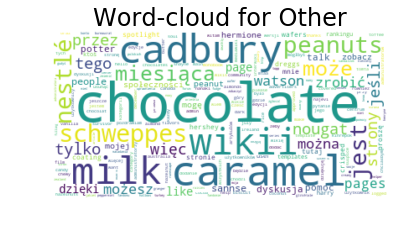

TV


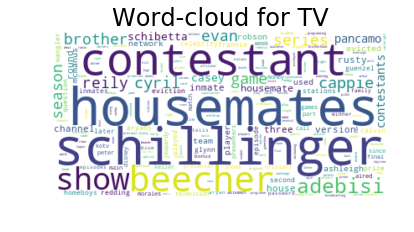

In [58]:
#Create wordclouds:
for k,v in TF_IDF.items():
    print(k)
    wordcloud = WordCloud(background_color='white')
    wordcloud.generate_from_frequencies(frequencies=(TF_IDF[k]))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title('Word-cloud for '+k)
    plt.axis("off")
    plt.savefig('graphs/wordcloud_'+k+'.png')
    plt.show() 


### 3.7 Sentiment

##### Goal
A sentiment analysis is very interesting in this project, since it can show whether som hubs use a more negative language than others. It is assumed by the genereal that a hub like gaming would have a more negative or even agressive tone than e.g. books. 

##### Tools
To create this analysis a dataset of the name *journal.pone.0026752.s001.TXT* is used. This is based of a study, where every word is rathed to see whether the words are more positive than negative. The data can be found at http://neuro.imm.dtu.dk/wiki/LabMT under the name Language Assessment by Mechanical Turk (labMT). 

Besides the data only basic tools have been applied, such as dataframes from pandas and numpy.

##### Application
The following sentiment analysis focus on 25 wikis from ever hub. The filtered data from the previous analysis is re-used. The application used will be explained thoughout the steps and code below, however to give an overview the cells contain the collowing code-segments:
* Load Data
* Methode for sentiment calculation on multiple words
* Calculating sentiment for the 25 wikis in every hub
* Create histogram over sentiment distribution
* Caluculate mean and standard-diviation
* Find positive words in hubs
* WordCloud of positive words
* Find negative words in hubs
* WordCloud of negative words

Now the the code. Explaination of the particular code bits are commented inside the code-cells.

In [59]:
### Get Dataset from labMT ###

# Headlines
names=["word", "happiness_rank","happiness_average", "happiness_standard_deviation", 
       "twitter_rank", "google_rank", "nyt_rank", "lyrics_rank"]

# Get data
dsS1 = pd.read_csv('data/journal.pone.0026752.s001.TXT', header=None, delimiter="\t", names=names, skiprows=[0,1,2,3])
dsS1.head()

word  happiness_rank  happiness_average  happiness_standard_deviation  \
0   laughter               1               8.50                        0.9313   
1  happiness               2               8.44                        0.9723   
2       love               3               8.42                        1.1082   
3      happy               4               8.30                        0.9949   
4    laughed               5               8.26                        1.1572   

  twitter_rank google_rank nyt_rank lyrics_rank  
0         3600          --       --        1728  
1         1853        2458       --        1230  
2           25         317      328          23  
3           65        1372     1313         375  
4         3334        3542       --        2332

In [ ]:
### Methode to calculate sentiment of multiple tokens ###

# ds is the data set S1 as a dataframe
def calculates_sentiment(tokens, ds):
    if len(tokens)==0:
        return 0
    
    words = [word for word in tokens if word in ds['word'].values]
    normalization = len(words)
    
    # return 0 if no sentiment is found
    if normalization==0:
        return 0
    
    sums = sum(ds.loc[ds['word'] == word]['happiness_average'].values[0] for word in words)
    return sums/normalization

In [ ]:
### Calculating the Sentiment for all wikis in the hub ###

sentiment_hub = {}
for k,v in hub_articles_wiki_filtered.items():
    if k not in sentiment_hub:
        sentiment_hub[k] = []
    print(k, len(v), end=', ')
    for wiki, text in list(v.items()):
        sentiment_hub[k].append((wiki,(calculates_sentiment(text, dsS1))))
    print()
        

Books 25

The sentiment for 25 wikis in the different hubs have been calculated and to see the distribution of these sentiments the following histagram have been created.

In [ ]:
### Create Histogram ###
sentiment_hub_hist = {}
for k,v in sentiment_hub.items():
    sentiment_hub_hist[k] = [s[1] for s in v]

createHistigram("Sentiment", "Wikis", "Sentiment Analysis", "Sentiment_Analysis", sentiment_hub_hist, 10, 5)

The above graphs shows that all the articles are close to neutral, and mostly positive. It looks like the TV hub has the larges span, while Lyfestyle is very neutrally centered in the middel. 

In [ ]:
### Calculate mean and variance for every hub ####
m_hub = {}
o_hub = {}

for k,v in sentiment_hub_hist.items():
    m_hub[k] = np.average(v)
    o_hub[k] = np.std(v)
    
    print("%s: average: %s, std: %s" % (k, m_hub[k], o_hub[k]))

To really understand the sentients the mean and variation has been found. It can be seen than the average are all very close, where Movies have the lowest and Other have the highest. The variation are all very close, however the bigget is easilly TV, and the smallest is Music.

The following sekment will look into which positive and negative words are used in the hubs

In [ ]:
# Quick function to find a specific words sentiment
def word_sentiment(word, average, ds):
    if word in ds['word'].values:
        return ds.loc[ds['word'] == word]['happiness_average'].values[0]
    return average

In [ ]:
### Finding the top positive words in every hub ###
# Positive words

positive_hub = {}

for k,v in hub_articles_wiki_filtered.items():
    limit = m_hub[k]+10*o_hub[k]
    for wikis in v.values():
        positive_hub[k] = " ".join([word for word in wikis if word_sentiment(word,m_hub[k],dsS1)>limit]) 
        
    print("%s: positive words: %s" % (k, positive_hub[k][:50]))
    print(len(positive_hub[k]))

Wordclouds for positive words

In [ ]:
### Create wordclouds for the positive words ###
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(30, 50))
c=0
r=0
for k, words in positive_hub.items():
    
    wordcloud = WordCloud(background_color='white').generate(positive_hub[k])
    axs[r][c].imshow(wordcloud, interpolation="bilinear")
    axs[r][c].set_title('Word-cloud for positive words in '+k)
    axs[r][c].axis("off")
    
    if c<1:
        c+=1
    else:
        r+=1
        c=0

plt.savefig('graphs/positive_wordCloud.png')
plt.show() 



In [ ]:
### Finding the top negative words in every hub ###
# Negative words

negativ_hub = {}

for k,v in hub_articles_wiki_filtered.items():
    for wikis in v.values():
        limit = m_hub[k]-10*o_hub[k]
        negativ_hub[k] = " ".join([word for word in wikis if word_sentiment(word,m_hub[k],dsS1)<limit]) 
        
    print("%s: negative words: %s" % (k, negativ_hub[k][:50]))

Wordclouds for negative words

In [ ]:
### Create wordclouds for the negative words ###
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(30, 50))
c=0
r=0
for k, words in negative_hub.items():
    
    wordcloud = WordCloud(background_color='white').generate(negative_hub[k])
    axs[r][c].imshow(wordcloud, interpolation="bilinear")
    axs[r][c].set_title('Word-cloud for negative words in '+k)
    axs[r][c].axis("off")
    
    if c<1:
        c+=1
    else:
        r+=1
        c=0

plt.savefig('graphs/negative_wordCloud.png')
plt.show() 



#### Discussion

The sentiment analysis has given an idea to how people behaive on the different hubs. It seems like music is mainly positive, while fans are more critical when it comes to movies.

## 4 Discussion

* What went well?,
* What is still missing? What could be improved?, Why?